This scripts reproduces the relax pattern analysis using likelihood ratio test DEGs called by sleuth.
LR should be more appropriate than Wald, as mentioned by developpers.

In [1]:
import pandas, numpy, termcolor, seaborn
import scipy, scipy.stats

In [2]:
import matplotlib, matplotlib.pyplot
matplotlib.rcParams.update({'font.size':20, 'font.family':'sans-serif', 'xtick.labelsize':30, 'ytick.labelsize':30, 'figure.figsize':(16, 9), 'axes.labelsize':40})

# 0. user-defined variables

In [3]:
# drangajokull
DEG_folder = '/home/adrian/projects/reynisfjara/results/DEGs_sleuth/'
expression_file = '/home/adrian/projects/reynisfjara/results/tpm/sleuth_TPM_gene.csv'

annotation_file = '/home/adrian/projects/reynisfjara/results/annotation/annotation.csv'
dorothea_file = '/home/adrian/software/dorothea/mmusculus/mmusculus.dorothea.txt'

In [30]:
# necio5
DEG_folder = '/Users/adrian/gd15/tmp/reynisfjara_tempo/DEGs_sleuth/'
expression_file = '/Users/adrian/gd15/tmp/reynisfjara_tempo/sleuth_TPM_gene.csv'

annotation_file = '/Users/adrian/gd15/tmp/reynisfjara_tempo/annotation.csv'
dorothea_file = '/Users/adrian/gd15/tmp/reynisfjara_tempo/mmusculus.dorothea.txt'

In [5]:
mice = ['a3922', 'a4774', 'a4775', 'a4776']
times = ['0h', '48h', '72h']
numerical_times = [0, 48, 72]

# 1. read data

## 1.1. read expression

In [6]:
expression = pandas.read_csv(expression_file, sep=',', index_col=0)
expression.head()

,a3922_0h_1,a3922_0h_2,a3922_0h_3,a3922_48h_1,a3922_48h_2,a3922_48h_3,a3922_72h_1,a3922_72h_2,a3922_72h_3,a4774_0h_1,...,a4775_72h_3,a4776_0h_1,a4776_0h_2,a4776_0h_3,a4776_48h_1,a4776_48h_2,a4776_48h_3,a4776_72h_1,a4776_72h_2,a4776_72h_3
ENSMUSG00000000001,70.858869,67.179056,66.517375,81.861848,77.489075,70.854094,67.129660,72.872443,69.831027,60.885758,...,67.388986,65.794367,69.699430,68.146005,59.799927,66.423357,63.896714,64.310235,64.637999,64.687759
ENSMUSG00000000003,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ENSMUSG00000000028,6.457057,5.565796,5.086769,22.012606,21.543720,22.339772,19.053432,22.896946,20.433887,7.799455,...,14.342087,4.784545,3.919546,4.207112,6.702482,8.104330,8.976260,8.732827,9.355852,8.934475
ENSMUSG00000000037,0.239987,0.977034,0.266774,1.054613,1.251900,2.173192,0.980283,2.443527,1.803596,0.542594,...,0.973886,0.458734,0.556198,0.693947,2.656600,0.836882,1.843121,1.487803,1.964196,4.959732
ENSMUSG00000000049,0.066739,0.063029,0.100137,0.000000,0.077734,0.000000,0.059189,0.000000,0.000000,0.212834,...,0.749643,0.000000,0.133703,0.000000,0.000000,0.093305,0.121948,0.000000,0.000000,0.000000


# 1.2. read annotation

In [7]:
annotation = pandas.read_csv(annotation_file, sep=',', index_col='ens_gene')
annotation.drop(columns=['Unnamed: 0', 'target_id'], inplace=True)
annotation.drop_duplicates(inplace=True)
print(annotation.shape)
annotation.head()

(53193, 3)


,gene_biotype,description,ext_gene
ens_gene,,,
ENSMUSG00000064336,Mt_tRNA,mitochondrially encoded tRNA phenylalanine [So...,mt-Tf
ENSMUSG00000064337,Mt_rRNA,mitochondrially encoded 12S rRNA [Source:MGI S...,mt-Rnr1
ENSMUSG00000064338,Mt_tRNA,mitochondrially encoded tRNA valine [Source:MG...,mt-Tv
ENSMUSG00000064339,Mt_rRNA,mitochondrially encoded 16S rRNA [Source:MGI S...,mt-Rnr2
ENSMUSG00000064340,Mt_tRNA,mitochondrially encoded tRNA leucine 1 [Source...,mt-Tl1


# 2. transform expression to be more amenable to downstream analysis

## 2.1. retreive median expression over technical replicates

In [8]:
mice_expression = pandas.DataFrame()
for mouse in mice:
    for time in times:
        condition_labels = [label for label in expression.columns if mouse in label and time in label]
        mice_expression[mouse + '_' + time] = expression.loc[:, condition_labels].median(axis=1)
mice_expression.head()

,a3922_0h,a3922_48h,a3922_72h,a4774_0h,a4774_48h,a4774_72h,a4775_0h,a4775_48h,a4775_72h,a4776_0h,a4776_48h,a4776_72h
ENSMUSG00000000001,67.179056,77.489075,69.831027,61.431895,63.517095,61.381634,61.144257,65.723226,65.802481,68.146005,63.896714,64.637999
ENSMUSG00000000003,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ENSMUSG00000000028,5.565796,22.012606,20.433887,7.799455,7.762091,10.865097,9.153277,15.931611,15.545989,4.207112,8.104330,8.934475
ENSMUSG00000000037,0.266774,1.251900,1.803596,0.582819,1.347229,1.062233,0.516596,0.954984,1.646817,0.556198,1.843121,1.964196
ENSMUSG00000000049,0.066739,0.000000,0.000000,0.212834,0.000000,0.000000,0.158297,0.000000,0.424440,0.000000,0.093305,0.000000


## 2.2. generate simple expression over biological replicates

In [9]:
simple_expression = mice_expression.iloc[:, :3]
for label in simple_expression.columns:
    if 'a3922' in label:
        new_label = 'WT_' + label.split('_')[1]
        simple_expression.rename(columns = {label:new_label}, inplace=True)
simple_expression.head()

,WT_0h,WT_48h,WT_72h
ENSMUSG00000000001,67.179056,77.489075,69.831027
ENSMUSG00000000003,0.000000,0.000000,0.000000
ENSMUSG00000000028,5.565796,22.012606,20.433887
ENSMUSG00000000037,0.266774,1.251900,1.803596
ENSMUSG00000000049,0.066739,0.000000,0.000000


In [10]:
for time in times:
    condition_labels = [label for label in mice_expression.columns if time in label and 'a3922' not in label]
    simple_expression['MUT_' + time] = mice_expression.loc[:, condition_labels].median(axis=1)

simple_expression.head()

,WT_0h,WT_48h,WT_72h,MUT_0h,MUT_48h,MUT_72h
ENSMUSG00000000001,67.179056,77.489075,69.831027,61.431895,63.896714,64.637999
ENSMUSG00000000003,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ENSMUSG00000000028,5.565796,22.012606,20.433887,7.799455,8.104330,10.865097
ENSMUSG00000000037,0.266774,1.251900,1.803596,0.556198,1.347229,1.646817
ENSMUSG00000000049,0.066739,0.000000,0.000000,0.158297,0.000000,0.000000


# 3. identify signficance over the MUT mice

In [11]:
significants = []
for mouse in mice[1:]:
    print('working with mouse {}'.format(mouse))
    
    ### significance
    path = DEG_folder + mouse + '.t72overt0.LRT.csv'
    df = pandas.read_csv(path, sep=',', index_col='target_id')
    mouse_significants = df.index.to_list()
    print('\t significance detected for {} genes'.format(len(mouse_significants)))
    significants.append(set(mouse_significants))
    
consistent_significants = list(significants[0] & significants[1] & significants[2])
print('significant genes: {}'.format(len(consistent_significants)))

working with mouse a4774
	 significance detected for 3124 genes
working with mouse a4775
	 significance detected for 7285 genes
working with mouse a4776
	 significance detected for 8512 genes
significant genes: 2559


# 4. search for pattern based on regression

First each gene trajectory is discretized as [-2, -1, 0, 1, 2] for each WT and MUT conditions.

Discretization rules are:

    if max TPM < 2: 
        trajectory == 0

    elif log2 FC [-inf, -1]
        if P < 0.05
            trajectory == -2
        else:
            trajectory == -1
        
    elif log2 FC [-1, -log2(1.5)] 
        trajectory == -1
        
    elif log2 FC [-log2(1.5), log2(1.5)] 
        trajectory == 0
        
    elif log2 FC [log2(1.5), 1] 
        trajectory == 1
        
    elif log2 FC [1, inf] 
        if  P < 0.05:
            trajectory == 2
        else:
            trajectory == 1

Once you have this, you select all genes that have abs trajectory = 2 in MUT and significance.

Then you select the genes that have more than one unit of discrete trajectory difference between WT and MUT.

Then you select a slope difference > 1 between WT and MUT.

## 4.1. discretize genes

In [33]:
def trajectory_fitter(t, tt, y):
    
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(tt, y)
    fitted_y = slope*t + intercept
    fitted_y[fitted_y < 0] = 0
    fitted_y_max = numpy.max(fitted_y)
    fitted_y_log2_fc = numpy.log2((fitted_y[-1]+1) / (fitted_y[0]+1))
    
    return fitted_y, fitted_y_max, fitted_y_log2_fc

def discretizer(fitted_y_max, fitted_y_log2_fc):
    
    discrete_value = None
    
    if fitted_y_max < 2:
        discrete_value = 0
    
    else:
        if fitted_y_log2_fc < -1:
            discrete_value = -2
    
        elif -1 <= fitted_y_log2_fc < -numpy.log2(1.5):
            discrete_value = -1
        
        elif -numpy.log2(1.5) <= fitted_y_log2_fc <= numpy.log2(1.5):
            discrete_value = 0
        
        elif numpy.log2(1.5) < fitted_y_log2_fc <= 1:
            discrete_value = 1
        
        elif fitted_y_log2_fc > 1:
            discrete_value = 2
            
    #print(fitted_y_max, fitted_y_log2_fc, discrete_value)
            
    if discrete_value == None:
        print(fitted_y_log2_fc)
        raise ValueError('case not considered')
    
    return discrete_value

### MAIN 
discrete_results = {}      # a dictionary of lists for [WT, MUT]

fitted_trajectory_wt = {}  # used for heatmap
fitted_trajectory_mut = {} # used for heatmap

fitted_response_wt = {}    # used for scatter plot
fitted_response_mut = {}   # used for scatter plot

t = numpy.array(numerical_times)
tt = numpy.concatenate((numerical_times, numerical_times, numerical_times), axis=0)


### working with WT
labels = [label for label in mice_expression.columns if 'a3922' in label]
labels.sort()
#print(labels)
flat_wt=[]

for ensembl in mice_expression.index:
    
    y = mice_expression.loc[ensembl, labels].values
    fitted_y, fitted_y_max, fitted_y_log2_fc = trajectory_fitter(t, t, y)
    discrete_value = discretizer(fitted_y_max, fitted_y_log2_fc)
    
    fitted_trajectory_wt[ensembl] = fitted_y
    fitted_response_wt[ensembl] = fitted_y_log2_fc
    discrete_results[ensembl] = [discrete_value]
    
    if discrete_value == 0:
        flat_wt.append(ensembl)
        
print(len(flat_wt))
    
### working with MUT
labels = [label for label in mice_expression.columns if 'a3922' not in label]
labels.sort()
#print(labels)
respond_mut = []

for ensembl in mice_expression.index:
    
    y = mice_expression.loc[ensembl, labels].values
    fitted_y, fitted_y_max, fitted_y_log2_fc = trajectory_fitter(t, tt, y)
    discrete_value = discretizer(fitted_y_max, fitted_y_log2_fc)
    
    fitted_trajectory_mut[ensembl] = fitted_y
    fitted_response_mut[ensembl] = fitted_y_log2_fc
    discrete_results[ensembl].append(discrete_value)
    
    if numpy.abs(discrete_value) == 2:
        respond_mut.append(ensembl)

print(len(respond_mut))

33376
400


## 4.2. identify response genes

In [35]:
# rule 1: Once you have this, you select all genes that have abs trajectory = 2 in MUT and significance.
# rule 2: Then you select the genes that have more than one unit of discrete trajectory difference between WT and MUT.
# rule 3: Then you select a slope difference > 1 between WT and MUT.

response_genes = []
gained_function = 0; flipped = 0

for (ensembl, pattern) in discrete_results.items():
    if numpy.abs(pattern[1]) == 2 and ensembl in consistent_significants: # rule 1
        if numpy.abs(pattern[0] - pattern[1]) > 1: # rule 2
            delta = fitted_response_mut[ensembl] - fitted_response_wt[ensembl]
            if numpy.abs(delta) > 1: # rule 3
                response_genes.append(ensembl)
                
                gene_name = annotation.loc[ensembl]['ext_gene']
                print(f'{ensembl} {gene_name} pattern: {pattern}, delta MUT/WT: {delta}')
                if 0 in pattern:
                    gained_function = gained_function + 1
                else:
                    flipped = flipped + 1                
                    
print(f'Found {gained_function} gained function genes and {flipped} flipped genes.')

ENSMUSG00000001751 Naglu pattern: [0, -2], delta MUT/WT -1.3429872564445116
ENSMUSG00000003617 Cp pattern: [0, 2], delta MUT/WT 4.3786519690423145
ENSMUSG00000007872 Id3 pattern: [0, 2], delta MUT/WT 1.5494897569286605
ENSMUSG00000013653 1810065E05Rik pattern: [0, -2], delta MUT/WT -1.1925085344892166
ENSMUSG00000014444 Piezo1 pattern: [0, -2], delta MUT/WT -1.1896325286923874
ENSMUSG00000015467 Egfl8 pattern: [-1, 2], delta MUT/WT 2.370375061845209
ENSMUSG00000015766 Eps8 pattern: [0, -2], delta MUT/WT -1.1290365465880123
ENSMUSG00000016496 Cd274 pattern: [0, 2], delta MUT/WT 2.1798170085229396
ENSMUSG00000021281 Tnfaip2 pattern: [0, -2], delta MUT/WT -1.5075511680332145
ENSMUSG00000022243 Slc45a2 pattern: [0, -2], delta MUT/WT -1.4263240882943296
ENSMUSG00000022676 Snai2 pattern: [-1, 2], delta MUT/WT 2.287563492763005
ENSMUSG00000022836 Mylk pattern: [0, 2], delta MUT/WT 1.598178645269328
ENSMUSG00000023009 Nckap5l pattern: [0, -2], delta MUT/WT -3.073079202703337
ENSMUSG00000024462

# 5. build scatter plot

Naglu	-1.343	1.834	tab:blue
Cp	4.379	1.368	tab:red
Id3	1.549	2.492	tab:red
1810065E05Rik	-1.193	0.506	tab:blue
Piezo1	-1.190	1.868	tab:blue
Egfl8	2.370	1.118	tab:red
Eps8	-1.129	2.573	tab:blue
Cd274	2.180	1.573	tab:red
Tnfaip2	-1.508	0.921	tab:blue
Slc45a2	-1.426	2.576	tab:blue
Snai2	2.288	1.478	tab:red
Mylk	1.598	0.957	tab:red
Nckap5l	-3.073	2.223	tab:blue
Gabbr1	1.668	1.732	tab:red
Chmp6	-1.508	1.860	tab:blue
Fam20c	-1.037	1.166	tab:blue
Eya1	-1.341	0.785	tab:blue
Ntmt1	-1.179	1.942	tab:blue
Frzb	1.424	1.803	tab:red
Tm4sf1	-1.436	2.524	tab:blue
Ddah1	-1.319	1.672	tab:blue
Cyp4b1	2.113	0.480	tab:red
Tinagl1	-1.192	2.325	tab:blue
Gpc2	1.384	0.245	tab:red
Fam131b	1.211	0.760	tab:red
Ttyh1	1.243	0.300	tab:red
Hpse	-2.564	1.279	tab:blue
Mcoln3	-3.065	0.355	tab:blue
Mex3c	1.088	1.818	tab:red
Abca8a	1.277	0.448	tab:red
Cystm1	-1.275	1.979	tab:blue
Sned1	1.539	0.955	tab:red
Zfta	1.277	1.282	tab:red
Fgfr3	1.256	1.097	tab:red
Ntrk3	-1.146	0.404	tab:blue
Syn3	1.345	0.680	tab:red
Lgals1	-1.354	3

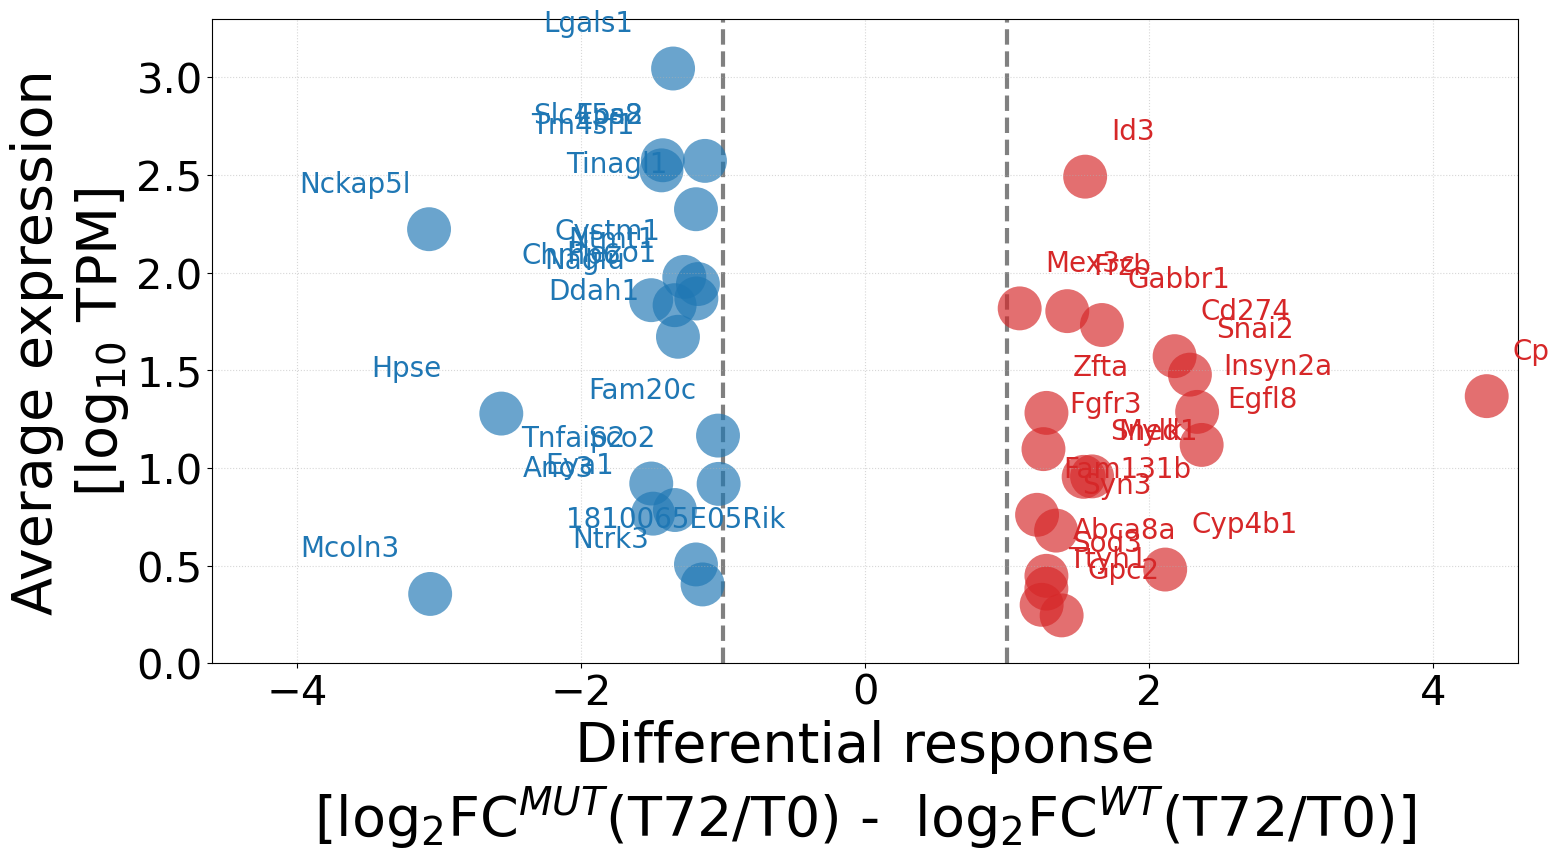

In [36]:
for ensembl in response_genes:
    
    gene_name = annotation.loc[ensembl]['ext_gene']
    locx =  fitted_response_mut[ensembl] - fitted_response_wt[ensembl]
    locy = numpy.mean(numpy.log10(mice_expression.loc[ensembl, :]))
    
    if locx > 1:
        the_color = 'tab:red'
        matplotlib.pyplot.text(locx+(11/60), locy+(11.5/60), gene_name, color=the_color)
    elif locx < -1:
        the_color = 'tab:blue'
        matplotlib.pyplot.text(locx-(11/12), locy+(11.5/60), gene_name, color=the_color)
    else:
        print(locx)
        print('error')
        
    # finally plotting the dot
    matplotlib.pyplot.scatter(locx, locy, s=1000, c=the_color, alpha=2/3, edgecolor='none')
    
    # printing for interpretation
    if the_color == 'tab:blue':
        printing_color = 'blue'
    elif the_color == 'tab:red':
        printing_color = 'red'
    else:
        printing_color = 'grey'
    message = '\t'.join([gene_name, '{:.3f}'.format(locx), '{:.3f}'.format(locy), the_color])
    print(termcolor.colored(message, printing_color))

matplotlib.pyplot.grid(alpha=0.5, ls=':')
matplotlib.pyplot.xlabel('Differential response\n[log$_2$FC$^{MUT}$(T72/T0) -  log$_2$FC$^{WT}$(T72/T0)]')
matplotlib.pyplot.ylabel('Average expression\n[log$_{10}$ TPM]')
matplotlib.pyplot.axvline(1, color='gray', ls='--', lw=3, zorder=0)
matplotlib.pyplot.axvline(-1, color='gray', ls='--', lw=3, zorder=0)
matplotlib.pyplot.xlim([-4.6, 4.6])
matplotlib.pyplot.ylim([0, 3.3])
matplotlib.pyplot.tight_layout()


## 5.1. scatter plot for weak pattern

In [ ]:
info = {}

for i in range(len(weak_pattern_genes)):
    ensembl = weak_pattern_genes[i]
    
    gene_name = annotation.loc[ensembl]['ext_gene']
    description = annotation.loc[ensembl]['description']
    locx = locations[ensembl][0]
    locy = locations[ensembl][1]
    info[ensembl] = [gene_name, description, locx, locy]
    
    if -1 < locx < 1:
        the_color = 'gray'
        matplotlib.pyplot.text(locx, locy, gene_name, color=the_color)
    elif locx > 1:
        the_color = 'tab:red'
        matplotlib.pyplot.text(locx+(11/60), locy+(11.5/60), gene_name, color=the_color)
    elif locx < -1:
        the_color = 'tab:blue'
        matplotlib.pyplot.text(locx-(11/12), locy+(11.5/60), gene_name, color=the_color)
    else:
        print(locx)
        print('error')
        
    # finally plotting the dot
    matplotlib.pyplot.scatter(locx, locy, s=1000, c=the_color, alpha=2/3, edgecolor='none')
    
    # printing for interpretation
    if the_color == 'tab:blue':
        printing_color = 'blue'
    elif the_color == 'tab:red':
        printing_color = 'red'
    else:
        printing_color = 'grey'
    message = '\t'.join([gene_name, '{:.3f}'.format(locx), '{:.3f}'.format(locy), the_color])
    print(termcolor.colored(message, printing_color))

matplotlib.pyplot.grid(alpha=0.5, ls=':')
matplotlib.pyplot.xlabel('Differential response\n[log$_2$FC$^{MUT}$(T72/T0) -  log$_2$FC$^{WT}$(T72/T0)]')
matplotlib.pyplot.ylabel('Average expression\n[log$_{10}$ TPM]')
matplotlib.pyplot.axvline(1, color='gray', ls='--', lw=3, zorder=0)
matplotlib.pyplot.axvline(-1, color='gray', ls='--', lw=3, zorder=0)
matplotlib.pyplot.xlim([-4.6, 4.6])
matplotlib.pyplot.ylim([0, 3.3])
matplotlib.pyplot.tight_layout()

In [ ]:
df = pandas.DataFrame.from_dict(info, orient='index', columns=['Gene name', 'Description', 'Response difference', 'Expression [log10 TPM]'])
df.sort_values(by='Response difference', inplace=True, ascending=False)

In [ ]:
reds = df[df['Response difference'] > 1]
print(reds.shape)
reds

In [ ]:
greys = df[(df['Response difference'] < 1) & (df['Response difference'] > -1)]
greys['Absolute response difference'] = greys['Response difference'].abs()
greys.sort_values(by='Absolute response difference', inplace=True, ascending=False)
print(greys.shape)
greys

In [ ]:
blues = df[df['Response difference'] < -1]
print(blues.shape)
blues.sort_values(by='Response difference', inplace=True)
blues

# 6. identify enrichment

In [ ]:
for ensembl in strong_pattern_genes:
    print(ensembl)

Mus musculus (REF)	upload_1 ( Hierarchy  NEW! Tips)  
Reactome pathways	#	#	expected	Fold Enrichment	+/-	P value  
HS-GAG degradation	22	3	.04	85.70	+	1.37E-02  
Unclassified	12955	12	20.61	.58	-	0.00E00  


Naglu, Gpc2 and Hpse.

# 6. build heatmap

In [ ]:
container = {}
for ensembl in strong_pattern_genes:
    full = numpy.concatenate((fitted_trajectory_mut[ensembl], fitted_trajectory_wt[ensembl]), axis=0)
    container[ensembl] = full
    
df = pandas.DataFrame.from_dict(container, orient='index', columns=['MUT_0h', 'MUT_48h', 'MUT_72h','WT_0h', 'WT_48h', 'WT_72h'])
df.head()

new_index = {}
for ensembl in df.index:
    gene_name = annotation.loc[ensembl]['ext_gene']
    new_index[ensembl] = gene_name
df.rename(index=new_index, inplace=True)

In [ ]:
zscore_df = scipy.stats.zscore(df, axis=1)
zscore_df.head()

In [ ]:
print(numpy.max(zscore_df.max()))
print(numpy.min(zscore_df.min()))

top = 2.5; bottom = -2.5
top_white = 5/6; bottom_white = -5/6

In [ ]:
# edited from https://stackoverflow.com/questions/59270751/how-to-make-a-diverging-color-bar-with-white-space-between-two-values-matplotlib
p = [bottom, bottom_white, top_white, top]
f = lambda x: numpy.interp(x, p, [0, 0.5, 0.5, 1])
new_cmap = matplotlib.colors.LinearSegmentedColormap.from_list('map_white', list(zip(numpy.linspace(0,1), matplotlib.pyplot.cm.bwr(f(numpy.linspace(min(p), max(p)))))))

In [ ]:
linkage_method = 'ward'
distance_metric = 'euclidean'
seaborn.set(font_scale=0.9)

h = seaborn.clustermap(zscore_df, cmap=new_cmap, col_cluster=False, vmin=bottom, vmax=top, method=linkage_method, metric=distance_metric, yticklabels=1, xticklabels = ['MUT 0h', 'MUT 48h', 'MUT 72h', 'WT 0h', 'WT 48h', 'WT 72h'], cbar_kws={'label':'Expression (z-score)'})

ordered_gene_names = [element.get_text() for element in h.ax_heatmap.get_yticklabels()]

matplotlib.pyplot.title('{} {}'.format(linkage_method, distance_metric))
matplotlib.pyplot.tight_layout()

matplotlib.pyplot.show()

#matplotlib.pyplot.savefig('heatmap.svg')

# 7.build dynamics

In [ ]:
seaborn.reset_orig()
matplotlib.rcParams.update({'font.size':12, 'font.family':'sans-serif', 'xtick.labelsize':12, 'ytick.labelsize':12, 'figure.figsize':(16/2, 9/2), 'axes.labelsize':12})

In [ ]:
strong_pattern_gene_names = [annotation.loc[ensembl]['ext_gene'] for ensembl in strong_pattern_genes]
strong_pattern_gene_names.sort()

In [ ]:
for gene_name in strong_pattern_gene_names:
    ensembl = annotation[annotation['ext_gene'] == gene_name].index.to_list()[0]
    ensembl_trajectory = []; ensembl_times = []
    for mouse in mice:
        
        ### plot error bars based on mean and std values
        plotting_means = []
        plotting_stds = []
        for time in times:
            working_labels = [label for label in expression.columns if mouse in label and time in label]
            #print(working_labels)
            values = expression.loc[ensembl, working_labels]
            plotting_means.append(numpy.mean(values))
            plotting_stds.append(numpy.std(values))
            
        # plot data
        if mouse == 'a3922':
            the_color = 'black'
        elif mouse == 'a4774':
            the_color = 'gold'
        elif mouse == 'a4775':
            the_color = 'tab:orange'
        elif mouse == 'a4776':
            the_color = 'tab:purple'
        else:
            print('error')
        matplotlib.pyplot.errorbar(numerical_times, plotting_means, yerr=plotting_stds, color=the_color, lw=0, elinewidth=4, alpha=2/3)
        matplotlib.pyplot.plot(numerical_times, plotting_means, 'o', color=the_color, ms=20)
        
    ### plot the regression lines based on mice expresssion
    labels = [label for label in mice_expression.columns if 'a3922' in label]
    labels.sort()    
    y = mice_expression.loc[ensembl, labels].values
    t = numpy.array(numerical_times)
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(t, y)
    fitted_y = slope*t + intercept
    fitted_y[fitted_y < 0] = 0
    matplotlib.pyplot.plot(t, fitted_y, '-', color='black', lw=5, zorder=0)
    
    labels = [label for label in mice_expression.columns if 'a3922' not in label]
    labels.sort()
    y = mice_expression.loc[ensembl, labels].values
        
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(catt, y)
    fitted_y = slope*t + intercept
    fitted_y[fitted_y < 0] = 0
    matplotlib.pyplot.plot(t, fitted_y, '-', color='tab:red', lw=5, zorder=0)
        
    # close figure
    matplotlib.pyplot.grid(alpha=0.5, ls=':')
    matplotlib.pyplot.title(gene_name, fontweight='bold')
    matplotlib.pyplot.xlabel('Time [h]')
    matplotlib.pyplot.ylabel('Expression [TPM]')
    matplotlib.pyplot.tight_layout()
    matplotlib.pyplot.show()

# Appendix 1 --- Analysis for direct targets

In [ ]:
dorothea = pandas.read_csv(dorothea_file, sep='\t', index_col=0)
print(dorothea.shape)
dorothea.head()

In [ ]:
direct_targets = dorothea[dorothea['tf'] == 'Mitf']
print(direct_targets.shape)
direct_targets.head()

In [ ]:
direct_targets_names = direct_targets['target'].to_list()
print(len(direct_targets_names))

In [ ]:
# define intersect
print(len(direct_targets_names), direct_targets_names)
print(len(strong_pattern_gene_names), strong_pattern_gene_names)
successes = list(set(direct_targets_names) & set(strong_pattern_gene_names))
print(successes)

In [ ]:
seaborn.reset_orig()
matplotlib.rcParams.update({'font.size':20, 'font.family':'sans-serif', 'xtick.labelsize':30, 'ytick.labelsize':30, 'figure.figsize':(16, 9), 'axes.labelsize':40})

#  plot the behaviour of the Mitf direct target genes

catt = numpy.concatenate((numerical_times, numerical_times, numerical_times), axis=0)

fitted_trajectory_wt = {}; fitted_trajectory_mut = {}

for gene_name in direct_targets_names:
    
    ensembl = annotation[annotation['ext_gene'] == gene_name].index[0]
    
    ### determine fitted response in WT
    labels = [label for label in mice_expression.columns if 'a3922' in label]
    labels.sort()
    y = mice_expression.loc[ensembl, labels].values
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(numerical_times, y)
    fitted_y = slope*t + intercept
    fitted_y[fitted_y < 0] = 0
    fitted_response_wt = numpy.log2((fitted_y[-1]+1) / (fitted_y[0]+1))
    fitted_trajectory_wt[ensembl] = fitted_y
    
    ### determine fitted response in MUT
    labels = [label for label in mice_expression.columns if 'a3922' not in label]
    labels.sort()
    y = mice_expression.loc[ensembl, labels].values
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(catt, y)
    fitted_y = slope*t + intercept
    fitted_y[fitted_y < 0] = 0
    fitted_response_mut = numpy.log2((fitted_y[-1]+1) / (fitted_y[0]+1))
    fitted_trajectory_mut[ensembl] = fitted_y
    
    # plot
    delta =  fitted_response_mut - fitted_response_wt
    average_expression = numpy.mean(numpy.log10(mice_expression.loc[ensembl, :]+1))
    if delta > 1:
        the_color = 'tab:red'
    elif delta < -1:
        the_color = 'tab:blue'
    else:
        the_color = 'grey'
    matplotlib.pyplot.scatter(delta, average_expression, s=1000, c=the_color, alpha=2/3, edgecolor='none')
    if average_expression > 0.5:
        matplotlib.pyplot.text(delta, average_expression, gene_name, color=the_color)
    
matplotlib.pyplot.grid(alpha=0.5, ls=':')
matplotlib.pyplot.xlabel('Differential response\n[log$_2$FC$^{MUT}$(T72/T0) -  log$_2$FC$^{WT}$(T72/T0)]')
matplotlib.pyplot.ylabel('Average expression\n[log$_{10}$ TPM]')
matplotlib.pyplot.axvline(1, color='gray', ls='--', lw=3, zorder=0)
matplotlib.pyplot.axvline(-1, color='gray', ls='--', lw=3, zorder=0)
matplotlib.pyplot.xlim([-4.6, 4.6])
matplotlib.pyplot.ylim([0, 4.5])
matplotlib.pyplot.tight_layout()

In [ ]:
# heatmap
container = {}

for gene_name in direct_targets_names:
    
    ensembl = annotation[annotation['ext_gene'] == gene_name].index[0]
    #print(ensembl, fitted_trajectory_mut[ensembl])
    full = numpy.concatenate((fitted_trajectory_mut[ensembl], fitted_trajectory_wt[ensembl]), axis=0)
    container[ensembl] = full
    #print(container[ensembl])
    
df = pandas.DataFrame.from_dict(container, orient='index', columns=['MUT_0h', 'MUT_48h', 'MUT_72h','WT_0h', 'WT_48h', 'WT_72h'])
df.head()

new_index = {}
for ensembl in df.index:
    gene_name = annotation.loc[ensembl]['ext_gene']
    new_index[ensembl] = gene_name
df.rename(index=new_index, inplace=True)

In [ ]:
zscore_df = scipy.stats.zscore(df, axis=1)
zscore_df.fillna(0, inplace=True)
zscore_df.head()

In [ ]:
working line

# Appendix 2 --- identify the number of filtered DEGs that separate time and biological differences.

## A.2.1. PCA on top highly expressed genes

## A.2.2. for time, retain union of time for each mouse.

## A.2.3. for biological differences, retain union of WT vs each MUT